# Predicting barotropic tides with FES and pyTMD

Predictions are verified agains sea level observations from the Bayonne-Boucau tide gauge ([DATA.SHOM.FR](https://data.shom.fr))

[pyTMD tutorials](https://pytmd.readthedocs.io/en/latest/user_guide/Examples.html)

Link to [FES data](https://www.aviso.altimetry.fr/en/data/products/auxiliary-products/global-tide-fes/description-fes2014.html)


In [1]:
import os

import numpy as np
import xarray as xr
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

import pynsitu as pin
crs = pin.maps.crs
import pynsitu.tides as td

/Users/aponte/.miniconda3/envs/insitu/lib/python3.10/site-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
/Users/aponte/.miniconda3/envs/insitu/lib/python3.10/site-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


---

## load and inspect tide gauge data

In [2]:
prod = False

In [3]:
tg = xr.open_dataset("data/94_2024.nc")
tg = tg.rename(Source4="sea level", TIME="time")

# extract lon/lat
lon_tg, lat_tg = float(tg.LONGITUDE), float(tg.LATITUDE)

# area of interest
extent = [-3, -1, 43.2, 44.5]
plot_map = lambda: pin.maps.plot_map(extent=extent, land=True, coastline=False)

#time = pd.date_range(start="2023/03/01", end="2023/08/01", freq="30T")
time = pd.to_datetime(tg.time)

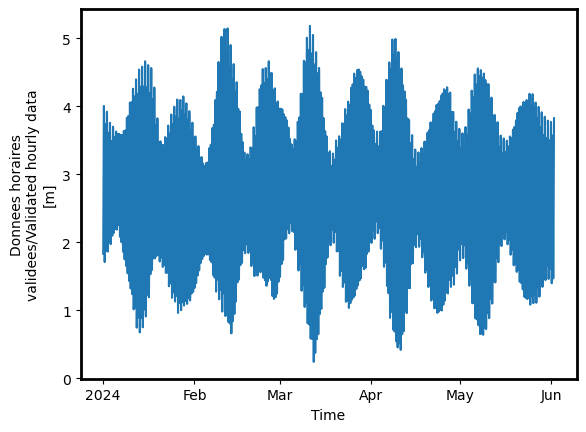

In [4]:
tg["sea level"].plot()

---

## harmonic amplitudes in the area of interest

In [5]:
# positions of interest
moorings = dict(
    bayonne = [lon_tg-.05, lat_tg], # offset tide gauge to be in water
    offshore = [-2.4, 44.4],
)
mo = (pd.DataFrame(moorings)
      .T
      .rename(columns={0: "lon", 1: "lat"})
      .to_xarray().rename(index="mooring")
)

In [6]:
# output 2d grid
dl_min = 0.0625 # potential resolution: 0.0625
lon, lat = (extent[0], extent[1], dl_min), (extent[2], extent[3], dl_min) # cp area

In [7]:
# load sea level and semi-diurnal constituents only
vtype = "z"
csts = td.major_semidiurnal
ds_2d = td.load_tidal_amplitudes(lon, lat, vtype, constituents=csts)
ds_moorings = td.load_tidal_amplitudes(mo.lon, mo.lat, vtype, constituents=csts)

broadcasting lon/lat


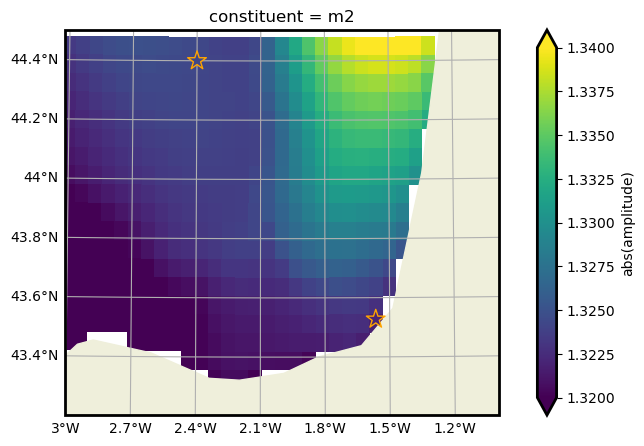

In [8]:
vmin = 1.32
vmax = 1.34

c = "m2"
    
#fig, ax = plot_map()
fig, ax, _ = plot_map()

_ds = ds_2d.sel(constituent=c)
(np.abs(_ds[vtype+"_amplitude"])
 .rename("abs(amplitude)")
 .plot(
     x="lon", y="lat",
     vmin=vmin,vmax=vmax,
     ax=ax, transform=crs,
 )
)

_ds = ds_moorings.sel(constituent=c)
h = ax.scatter(
    _ds.lon, _ds.lat, c=np.abs(_ds[vtype+"_amplitude"]), 
    s=200, edgecolors="orange", marker="*",
    #_ds.lon, _ds.lat, c="w", s=100, edgecolors="0.5",
    vmin=vmin,vmax=vmax,
    transform=crs,
    zorder=10,
)


In [9]:
# load on FES grid - needs update
#ds = td.load_raw_tidal_amplitudes(["z", "u", "v"], lon=lon, lat=lat, constituents=td.major_semidiurnal)
#ds.sea_level_phase.sel(constituents="m2").plot()
#np.real(ds.sea_level_amplitude*np.exp(1j*ds.sea_level_phase*np.pi/180)).sel(constituents="m2").plot()

### store all tidal harmonics

In [10]:
#prod = True
prod = False

nc = "bayonne_mooring_harmonics.nc"
if prod:
    ha = td.load_raw_tidal_amplitudes(["z", "u", "v"], lon=lon, lat=lat)
    ha.to_netcdf(nc, mode="w")
else:
    ha = xr.open_dataset(nc)

---

## tidal predictions

### just sea level and (m2, s2)

In [40]:
# just m2 and s2
ds = td.tidal_prediction(mo.lon, mo.lat, time, ["z",], constituents=td.major_semidiurnal, minor=False, split=True)
ds

<xarray.Dataset> Size: 206kB
Dimensions:       (mooring: 2, time: 3672, constituent: 2)
Coordinates:
  * mooring       (mooring) object 16B 'bayonne' 'offshore'
  * constituent   (constituent) object 16B 'm2' 's2'
    amplitude     (constituent) float64 16B 0.2441 0.1127
    phase         (constituent) float64 16B 1.732 0.0
    omega         (constituent) float64 16B 0.0001405 0.0001454
    alpha         (constituent) float64 16B 0.693 0.693
    species       (constituent) float64 16B 2.0 2.0
    omega_cpd     (constituent) float64 16B 1.932 2.0
  * time          (time) datetime64[ns] 29kB 2024-01-01 ... 2024-06-01T23:00:00
Data variables:
    lon           (mooring) float64 16B -1.565 -2.4
    lat           (mooring) float64 16B 43.53 44.4
    z_tide        (mooring, time) float64 59kB -1.423 -1.311 ... 0.6056 0.8539
    z_tide_split  (mooring, constituent, time) float64 118kB -1.16 ... -0.419

### individual constituent contributions

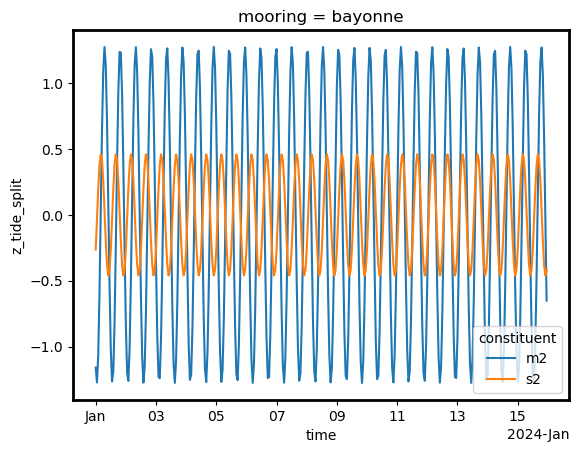

In [42]:
tlim = ("2024/01/01", "2024/01/15")
da = ds["z_tide_split"].sel(mooring="bayonne", time=slice(*tlim))
da.plot.line(hue="constituent")

### total sea level prediction

In [43]:
#prod = True
prod = False

# with full list of harmonics
nc = "bayonne_moorings_time_series.nc"
if prod:
    tp = td.tidal_prediction(mo.lon, mo.lat, time, split=True)
    tp.to_netcdf(nc, mode="w")
else:
    tp = xr.open_dataset(nc)

In [45]:
def plot_tseries(tg, tp, tlim=None):

    fig, ax = plt.subplots(1,1, figsize=(10,5))

    da = tg["sea level"]
    if tlim is not None:
        da = da.sel(time=slice(*tlim))
    da = da-da.mean("time")
    da.plot(color="k", lw=2)
    da_tg = da

    da = tp["z_tide"].sel(mooring="bayonne")
    if tlim is not None:
        da = da.sel(time=slice(*tlim))
    da.plot(hue="mooring")

    #ds["z_tide_minor"].sel(mooring="bayonne").plot()

    residual = da_tg - da
    residual.plot(label="residual")
    residual_rms = residual.std()

    ax.set_title(f"residual rms = {residual_rms*1e2:.1f} cm")

    ax.grid()

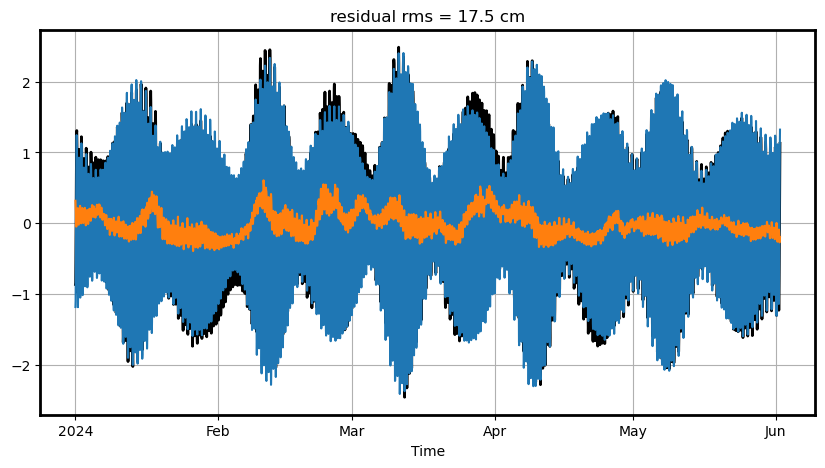

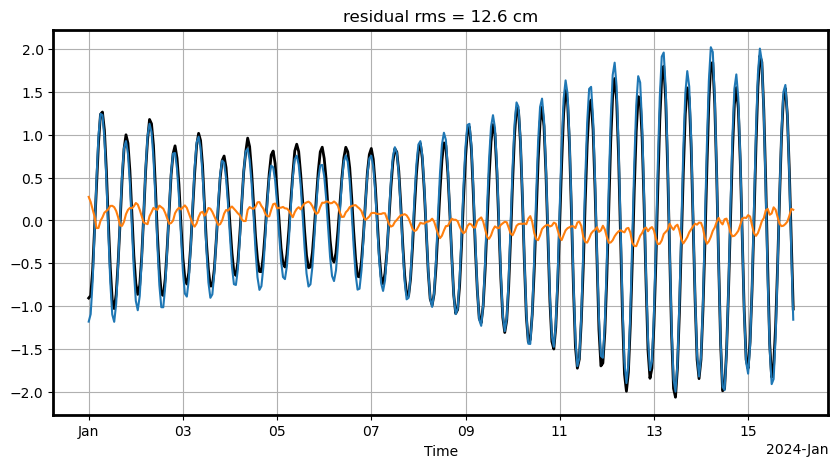

In [46]:
plot_tseries(tg, tp)
plot_tseries(tg, tp, tlim=("2024/01/01", "2024/01/15"))

---

## misc: constituents, frequencies, equilibrium tides

In [5]:
td.cproperties

,amplitude,phase,omega,alpha,species,omega_cpd
constituent,,,,,,
m3,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
eps2,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
n4,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
mtm,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
msqm,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
lambda2,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
mks2,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
r2,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000
s4,0.000000,0.000000,0.000000e+00,0.000,0.0,0.000000


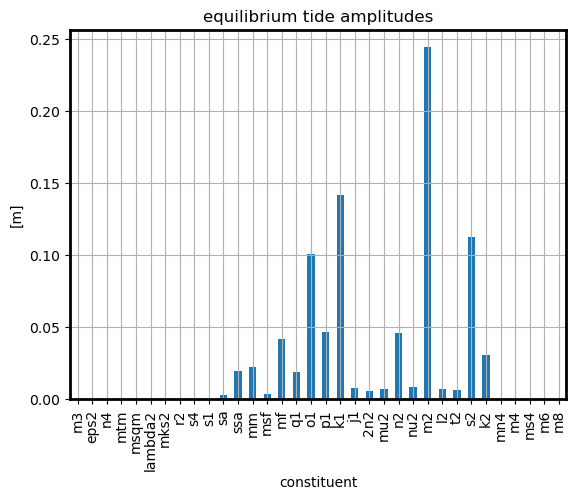

In [6]:
ax = td.cproperties.amplitude.plot.bar()
ax.set_title("equilibrium tide amplitudes")
ax.set_ylabel("[m]")
ax.grid()

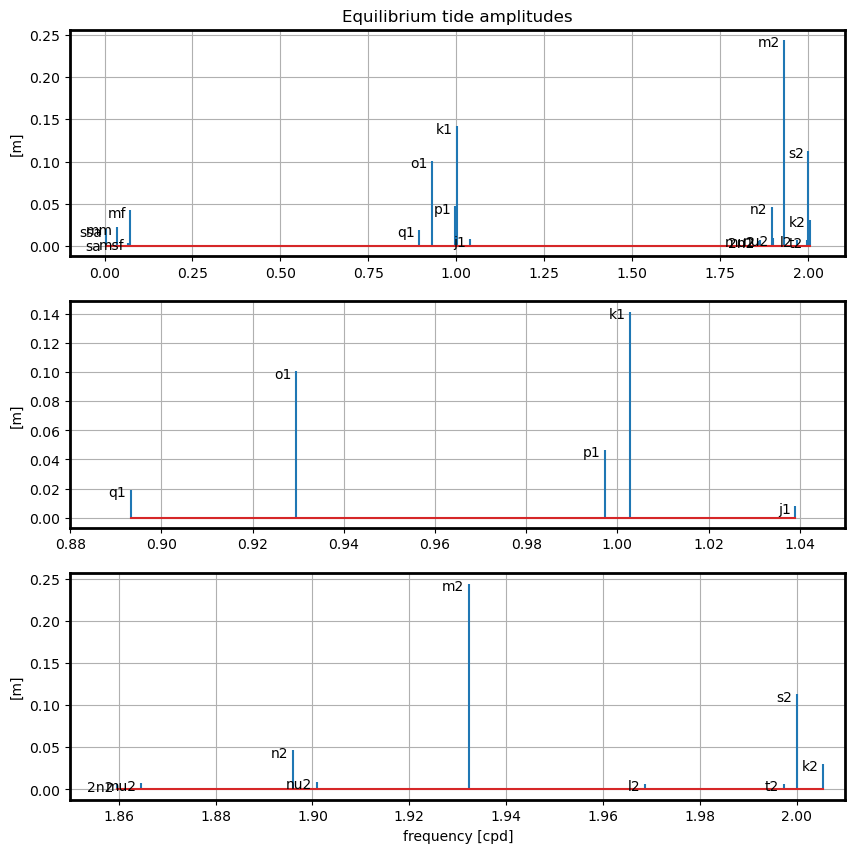

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(10,10))
td.plot_equilibrium_amplitudes(td.cproperties, axes[0])
td.plot_equilibrium_amplitudes(td.cproperties, ax=axes[1], xlim=(.88, 1.05))
td.plot_equilibrium_amplitudes(td.cproperties, ax=axes[2], xlim=(1.85, 2.01))

for i in range(0,2):
    axes[i].set_xlabel("")
for i in range(1,3):
    axes[i].set_title("")

### play with tidal arguments used for predictions

$
\begin{align}
\eta = \mathcal{R} \Big \{  \sum_k h_k \times f_k(t) h_c e^{i (g_k(t) + u_k(t) ) }  \Big \}
\end{align}
$

$g_k (t)$ is the equilibrium argument, it is common to all models
$f_l(t)$ and $u_k(t)$ are nodal corrections.


Constituents have unit complex amplitudes here:

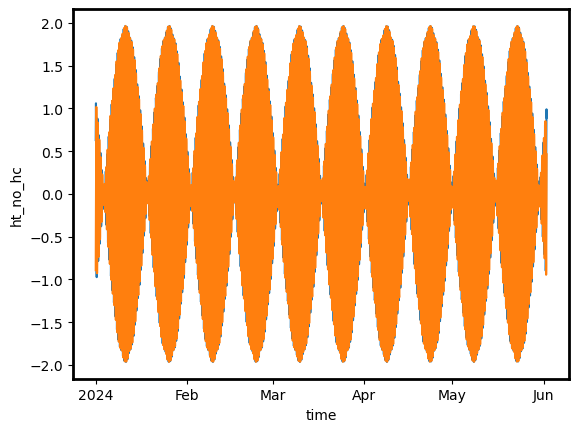

In [8]:
ds = td.get_tidal_arguments(time)

_ds = ds
#_ds = ds.isel(time=slice(0,24*28))
np.real(_ds["ht_no_hc"]).sel(constituent=td.major_semidiurnal).sum("constituent").plot()
np.imag(_ds["ht_no_hc"]).sel(constituent=td.major_semidiurnal).sum("constituent").plot()